Number of cars:8792 and notcars:8968 images.


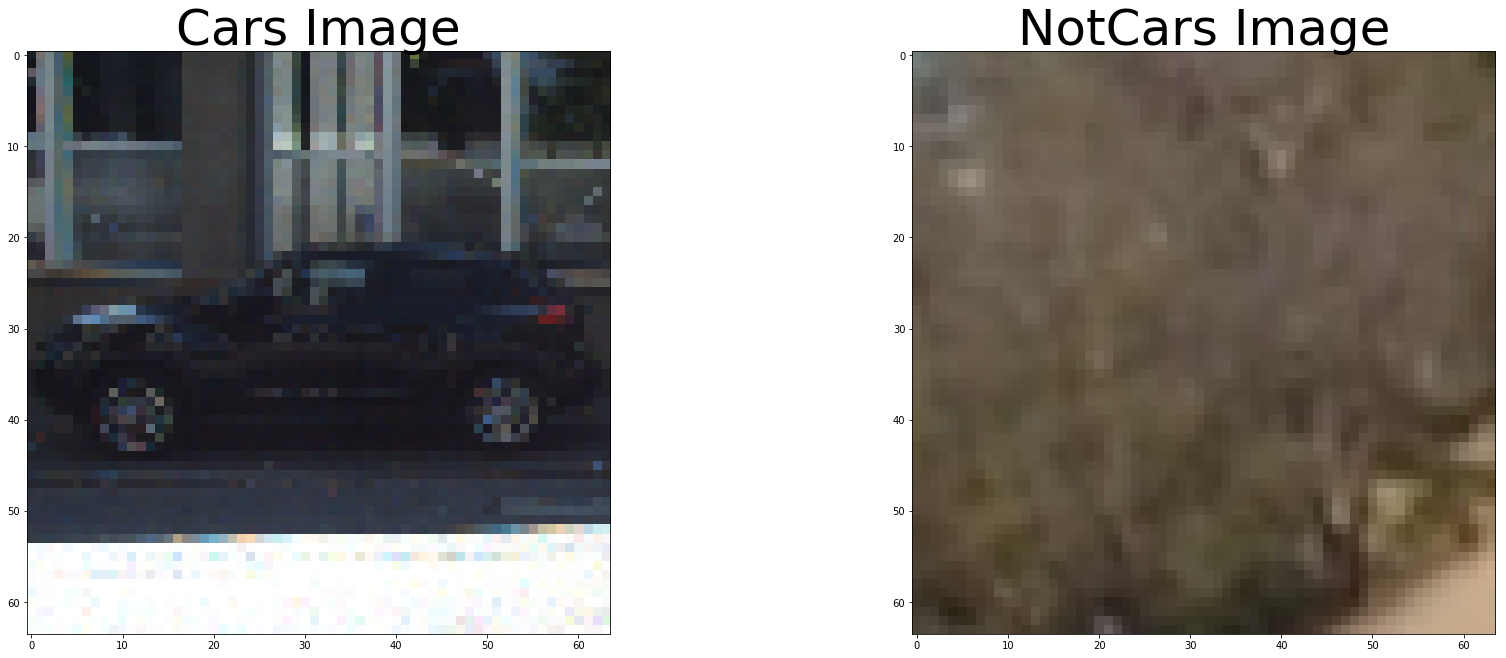

In [1]:
import numpy as np
import cv2
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from hog_classify import HogSVMClassifier
%matplotlib inline

from utils import *

hogsvmclassifier = HogSVMClassifier()

# Brief datasets analysis
print('Number of cars:{} and notcars:{} images.'.format(len(hogsvmclassifier.cars), len(hogsvmclassifier.notcars)))

# Show example images for both datasets
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(plt.imread(hogsvmclassifier.cars[0]))
ax1.set_title('Cars Image', fontsize=50)
ax2.imshow(plt.imread(hogsvmclassifier.notcars[0]))
ax2.set_title('NotCars Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [2]:
# helper fucntion to display comparison between input feature images and hog extracted features, broken down per channel
def show_hog_features( image, colormap = cv2.COLOR_RGB2YCrCb, orientations = 9, pixels_per_cell = 8, cells_per_block = 2 ):

    input_image = image
    # convert to desired colour map
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    # show input image
    fig_input = plt.figure()
    fig_input.set_figheight(5)
    fig_input.set_figwidth(5)
    plt.axis('off')
    plt.imshow(input_image)

    # compare all channel images with respective hog features
    fig = plt.figure()
    for i, channel in enumerate(range(image.shape[2])):
        __, hog_image = hogsvmclassifier.get_hog_features( img = image[:,:,channel], orient = orientations,
                                    pix_per_cell = pixels_per_cell, cell_per_block = cells_per_block,
                                    vis = True)
        # YCrCb channels as grayscale
        fig.add_subplot(2,image.shape[2],i + 1)
        fig.set_figheight(15)
        fig.set_figwidth(15)
        plt.axis('off')
        ax1.set_title('Channel: {}'.format(i), fontsize=50)
        plt.imshow(image[:,:,channel], cmap = 'gray')

        # Hog features per YCrCb channel
        fig.add_subplot(1,image.shape[2],i + 1)
        fig.set_figheight(15)
        fig.set_figwidth(15)
        plt.axis('off')
        ax1.set_title('Channel: {}'.format(i), fontsize=50)
        plt.imshow(hog_image)

    plt.show()


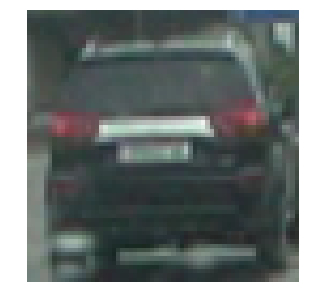

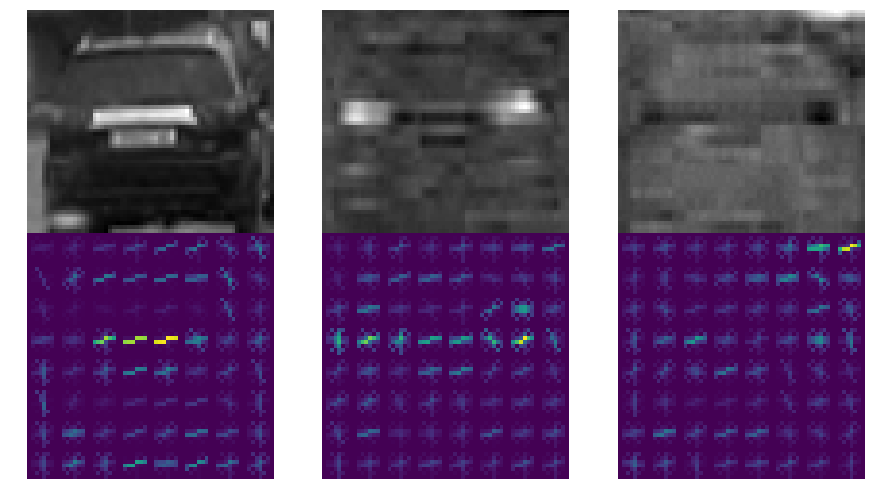

In [3]:
# Visualy analyse extracted hog features on single randomly chosen image from cars dataset.
image = mpimg.imread(hogsvmclassifier.cars[random.randint(0, len(hogsvmclassifier.cars))])
show_hog_features(image = image, colormap = cv2.COLOR_RGB2YCrCb)

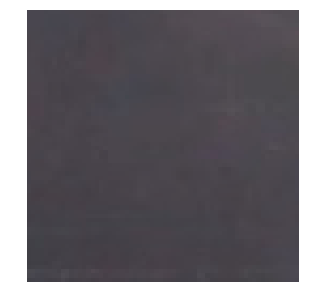

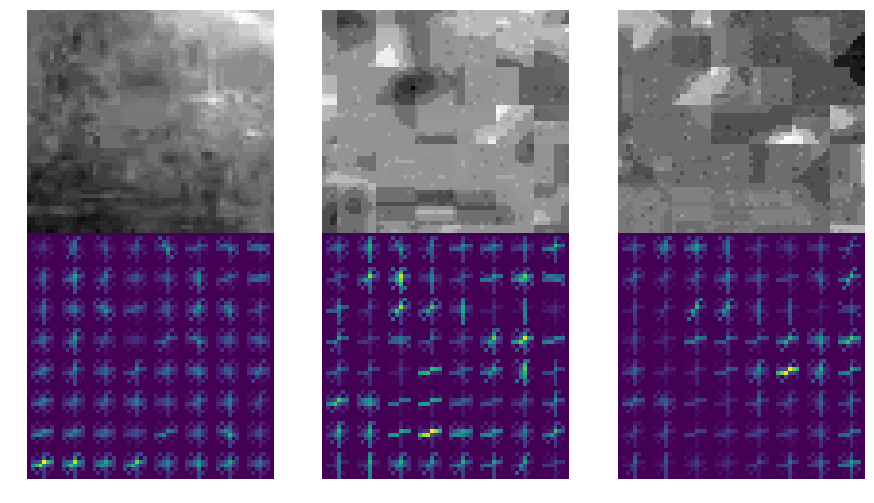

In [4]:
# And do same for single randomly chosen image from notcars dataset.
image = mpimg.imread(hogsvmclassifier.notcars[random.randint(0, len(hogsvmclassifier.notcars))])
show_hog_features(image = image, colormap = cv2.COLOR_RGB2YCrCb)

In [5]:
hogsvmclassifier.train_svm()

45.42 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
10.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9834
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.]
0.00147 Seconds to predict 10 labels with SVC


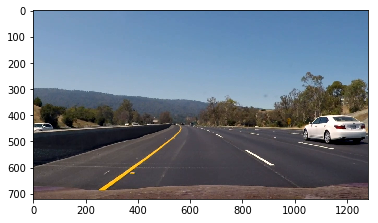

In [6]:
from moviepy.video.io.VideoFileClip import VideoFileClip

# load project video file
video = VideoFileClip("project_video.mp4")
video_out = 'project_video_out.mp4'

#video = video.subclip(t_start=28, t_end=32)

# get single frame on which different steps of pipeline will be executed
frame = video.get_frame(10)

# show original image from project file
plt.imshow(frame)

In [7]:
from window_search import find_cars
svc = hogsvmclassifier.svc
X_scaler = hogsvmclassifier.X_scaler
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32

ystart = 400
ystop = 656
scale = 1.5

img = frame
bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

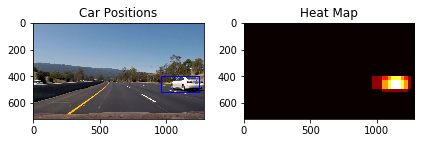

In [8]:
from tracking import *

box_list = bboxes
image = frame

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heat)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [9]:
from moviepy.video.io.VideoFileClip import VideoFileClip
from collections import deque

from car import Car
from tracking import *
from ytpipeline import Pipeline


video = VideoFileClip("project_video.mp4")
video_out = 'project_video_out.mp4'

tracker = Tracker(min_overlap = 0.75)
vis_debug = False


pipeline = Pipeline(tracker, vis_debug)


video_obj = video.fl_image(pipeline.ytpipeline)
video_obj.write_videofile(video_out, audio=False)


Using TensorFlow backend.


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [00:35<00:00, 35.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

